In [250]:
# general
import numpy as np
from numpy.random import PCG64, SeedSequence
import pandas as pd
import verde as vd
import xarray as xr
import skgstat as skg
from skgstat import models
import gstatsim as gsm
from scipy.interpolate import RBFInterpolator
from scipy.stats import qmc
from sklearn.preprocessing import QuantileTransformer
from tqdm.auto import tqdm

# plotting
import matplotlib.pyplot as plt

# io
from tqdm.auto import tqdm
import os
from pathlib import Path
import time
import numbers
import warnings

import sys
sys.path.append('..')

import gstatsim_custom as gsim

<module 'gstatsim' from 'C:\\Users\\mjfie\\mambaforge\\envs\\cryo\\lib\\site-packages\\gstatsim.py'>

In [6]:
ds = xr.load_dataset('test_data.nc')
#ds = ds.coarsen(x=2, y=2, boundary='trim').mean()
ds

<xarray.Dataset> Size: 4MB
Dimensions:                 (x: 200, y: 300)
Coordinates:
  * x                       (x) float32 800B -1.25e+06 -1.249e+06 ... -1.15e+06
  * y                       (y) float32 1kB -7.502e+05 -7.508e+05 ... -8.998e+05
Data variables: (12/14)
    surface_topography      (y, x) float32 240kB 1.985e+03 ... 2.275e+03
    bed_uncertainty         (y, x) float32 240kB 153.0 151.0 ... 167.0 163.0
    bed_topography          (y, x) float32 240kB 15.0 61.0 ... -353.0 -319.0
    mask                    (y, x) float32 240kB 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0
    ice_thickness           (y, x) float32 240kB 1.97e+03 ... 2.594e+03
    thickness_survey_count  (y, x) float32 240kB nan nan nan nan ... nan nan nan
    ...                      ...
    geoid                   (y, x) float64 480kB -35.0 -35.0 ... -38.0 -38.0
    bed_ell                 (y, x) float64 480kB -20.0 26.0 ... -391.0 -357.0
    surface_ell             (y, x) float64 480kB 1.95e+03 ... 2.237e+03
    thick_cond              (y, x) float64 480kB nan nan nan nan ... nan nan nan
    vx                      (y, x) float32 240kB -5.393 -3.659 ... 2.892 2.983
    vy                      (y, x) float32 240kB 14.38 14.35 ... 5.464 5.648
Attributes: (12/26)
    crs:                    EPSG:3031
    title:                  BEDMAP3 - Ice thickness, bed and surface elevatio...
    summary:                We present here Bedmap3, the latest suite of grid...
    keywords:               Antarctica,BEDMAP,Elevation,Ice thickness
    Conventions:            ACDD-1.3, CF-1.8
    citation:               Pritchard, H., Fretwell, P., Fremand, A., Bodart,...
    ...                     ...
    time_coverage_end:      2024-11-01
    geospatial_lon_min:     -180
    geospatial_lon_max:     180
    geospatial_lat_min:     -90
    geospatial_lat_max:     -60
    geospatial_bounds_crs:  EPSG:4326

In [7]:
bed_cond = ds.surface_topography.values - ds.thick_cond.values
xx, yy = np.meshgrid(ds.x, ds.y)

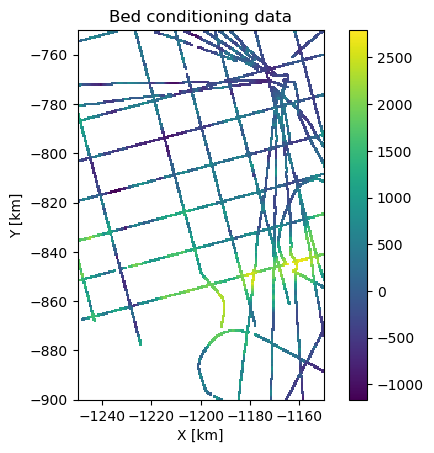

In [8]:
plt.pcolormesh(ds.x/1000, ds.y/1000, bed_cond)
plt.axis('scaled')
plt.xlabel('X [km]')
plt.ylabel('Y [km]')
plt.title('Bed conditioning data')
plt.colorbar()
plt.show()

In [9]:
cond_msk = ~np.isnan(bed_cond)
x_cond = xx[cond_msk]
y_cond = yy[cond_msk]
data_cond = bed_cond[cond_msk]

smoothing = 1e11
interp = RBFInterpolator(np.array([x_cond, y_cond]).T, data_cond, smoothing=smoothing)
trend = interp(np.array([xx.flatten(), yy.flatten()]).T).reshape(xx.shape)
res_cond = bed_cond - trend

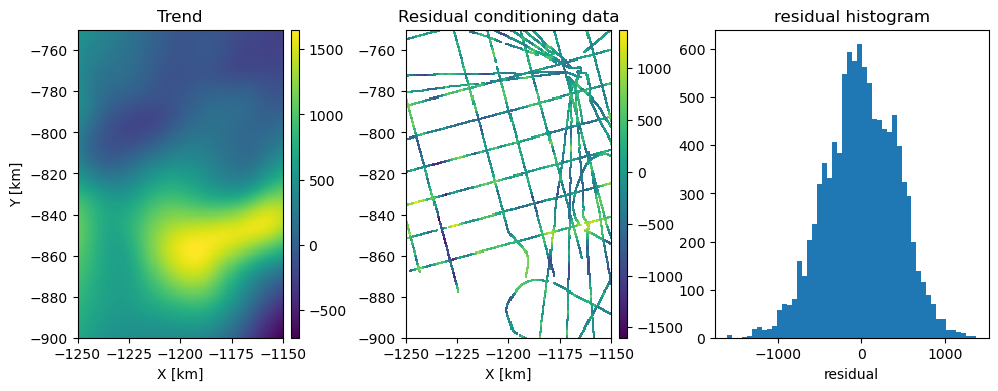

In [10]:
fig, axs = plt.subplots(1, 3, figsize=(12,4))
ax = axs[0]
im = ax.pcolormesh(ds.x/1000, ds.y/1000, trend)
ax.axis('scaled')
ax.set_xlabel('X [km]')
ax.set_ylabel('Y [km]')
ax.set_title('Trend')
plt.colorbar(im, ax=ax, pad=0.03, aspect=40)

ax = axs[1]
im = ax.pcolormesh(ds.x/1000, ds.y/1000, res_cond)
ax.axis('scaled')
ax.set_xlabel('X [km]')
ax.set_title('Residual conditioning data')
plt.colorbar(im, ax=ax, pad=0.03, aspect=40)

ax = axs[2]
ax.hist(res_cond[cond_msk], bins=50)
ax.set_xlabel('residual')
ax.set_title('residual histogram')

plt.show()

In [11]:
res_norm, nst_trans = utilities.gaussian_transformation(res_cond, cond_msk)
df_grid = pd.DataFrame({'X' : x_cond, 'Y' : y_cond, 'residual' : res_cond[cond_msk], 'NormZ' : res_norm[cond_msk]})

In [12]:
vgrams, experimental, bins = utilities.variograms(xx, yy, res_cond, maxlag=30e3, n_lags=20, downsample=10)

In [13]:
# evaluate models
xi =np.linspace(0, bins[-1], 100) 

y_exp = models.exponential(xi, *vgrams['exponential'])
y_gauss = models.gaussian(xi, *vgrams['gaussian'])
y_sph = models.spherical(xi, *vgrams['spherical'])
y_matern = models.matern(xi, *vgrams['matern'])

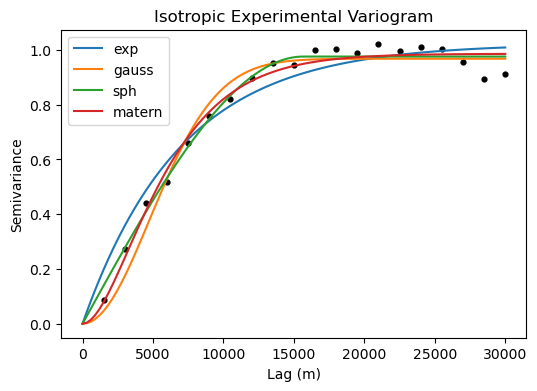

In [14]:
plt.figure(figsize=(6,4))
plt.scatter(bins, experimental, s=12, c='k')
plt.plot(xi, y_exp, label='exp')
plt.plot(xi, y_gauss, label='gauss')
plt.plot(xi, y_sph, label='sph')
plt.plot(xi, y_matern, label='matern')
plt.title('Isotropic Experimental Variogram')
plt.xlabel('Lag (m)'); plt.ylabel('Semivariance')
plt.legend()
plt.show()

In [15]:
vgrams['matern']

[np.float64(15170.521253030789),
 np.float64(0.9857828005329232),
 np.float64(1.617712940332448),
 0]

In [16]:
parameters = vgrams['matern']

# set variogram parameters
nugget = parameters[-1]
major_range = parameters[0]
minor_range = parameters[0]
sill = parameters[1]
smoothness = parameters[2]
nugget = parameters[-1]
azimuth = 0

In [17]:
rng = np.random.default_rng(0)

k = 20
rad = 50e3

In [51]:
# save variogram parameters as a list
vario_list = [azimuth, nugget, major_range, minor_range, sill, 'matern', smoothness]

pred_grid = np.stack([xx.flatten(), yy.flatten()]).T
sim = gsm.Interpolation.okrige_sgs(pred_grid, df_grid, 'X', 'Y', 'NormZ', k, vario_list, rad, quiet=False, seed=0)
sim_trans = nst_trans.inverse_transform(sim.reshape(-1,1)).squeeze()

100%|██████████| 60000/60000 [07:30<00:00, 133.19it/s]


In [52]:
res_sim_gsm = sim_trans.reshape(xx.shape)
bed_gsm = res_sim_gsm + trend

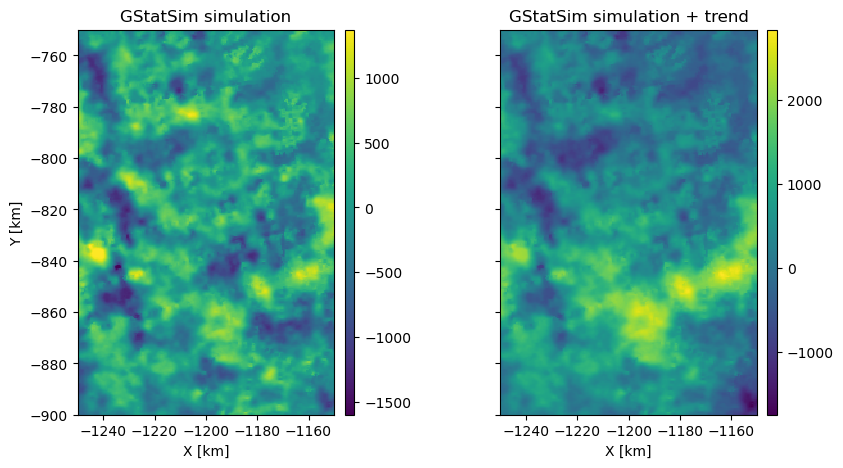

In [56]:
fig, axs = plt.subplots(1, 2, figsize=(10,5), sharey=True)
ax = axs[0]
im = ax.pcolormesh(ds.x/1000, ds.y/1000, res_sim_gsm)
ax.axis('scaled')
ax.set_xlabel('X [km]')
ax.set_ylabel('Y [km]')
ax.set_title('GStatSim simulation')
plt.colorbar(im, ax=ax, pad=0.03, aspect=40)

ax = axs[1]
im = ax.pcolormesh(ds.x/1000, ds.y/1000, bed_gsm)
ax.axis('scaled')
ax.set_xlabel('X [km]')
ax.set_title('GStatSim simulation + trend')
plt.colorbar(im, ax=ax, pad=0.03, aspect=40)
plt.show()

# New GStatSim variant is faster

* Changed to variogram being a dictionary so that the order does not matter
* The new sgs function takes the grid with conditioning data in it and NaN elsewhere. Does not use pandas DataFrame

In [54]:
vario = {
    'azimuth' : azimuth,
    'nugget' : nugget,
    'major_range' : major_range,
    'minor_range' : minor_range,
    'sill' : sill,
    's' : smoothness,
    'vtype' : 'matern',
}

res_newsim = interpolate.sgs(xx, yy, res_cond, vario, rad, k, seed=0)

  0%|          | 0/60000 [00:00<?, ?it/s]

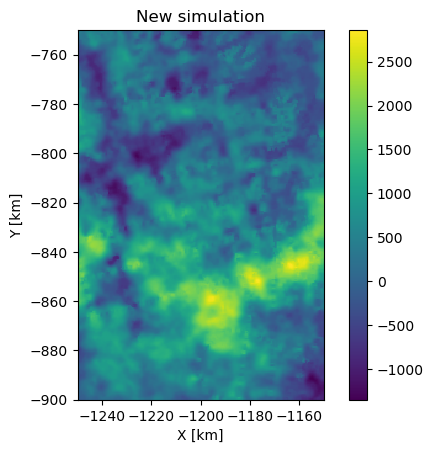

In [55]:
plt.pcolormesh(ds.x/1000, ds.y/1000, res_newsim + trend)
plt.axis('scaled')
plt.xlabel('X [km]')
plt.ylabel('Y [km]')
plt.title('New simulation')
plt.colorbar()
plt.show()

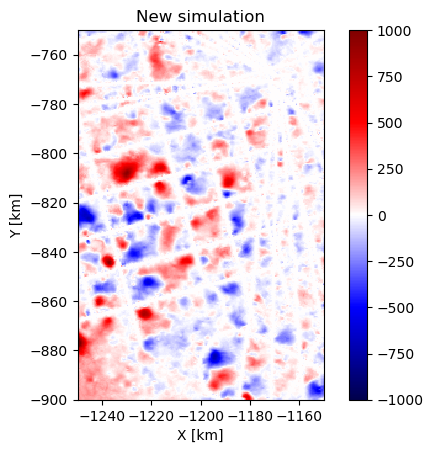

In [58]:
plt.pcolormesh(ds.x/1000, ds.y/1000, res_sim_gsm-res_newsim, vmin=-1000, vmax=1000, cmap='seismic')
plt.axis('scaled')
plt.xlabel('X [km]')
plt.ylabel('Y [km]')
plt.title('New simulation')
plt.colorbar()
plt.show()

In [21]:
sim_mask = np.ones(xx.shape).astype(bool)

ii, jj = np.meshgrid(np.arange(xx.shape[0]), np.arange(xx.shape[1]), indexing='ij')
inds = np.array([ii[sim_mask].flatten(), jj[sim_mask].flatten()]).T

In [28]:
# # calculate weights in parallel
# kweights = np.full((*res_cond.shape, k), np.nan)
# print(kweights.shape)

(300, 200, 59999)


In [29]:
from copy import deepcopy

kweights = np.full((*res_cond.shape, 20), np.nan)

for k in range(inds.shape[0]):
    cond_msk_tmp = deepcopy(cond_msk)
    cond_msk_tmp[inds[:k,0], inds[:k,1]] = True
    # if k%5000==0:
    #     print(f'{k}: {np.count_nonzero(cond_msk_tmp)}')

# We can have nonstationary variogram parameters

You can pass scalar values or arrays for any of the variogram parameters. Not implemented: different covariance models. Could turn string into an integer code and make 2D arrays of those.

In [19]:
# randomly sample with latin hypercube sampling
bounds = [-1.25e6, -0.9e6, -1.15e6, -0.75e6]
l_bounds = bounds[:2]
u_bounds = bounds[2:]

sampler = qmc.LatinHypercube(d=2, optimization="random-cd")
sample = sampler.random(n=50)
rescaled = qmc.scale(sample, l_bounds, u_bounds)

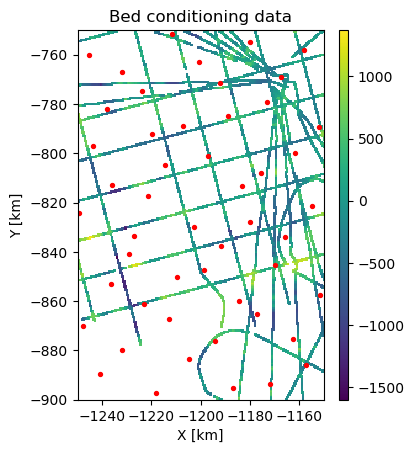

In [20]:
im = plt.pcolormesh(ds.x/1000, ds.y/1000, res_cond)
plt.scatter(rescaled[:,0]/1000, rescaled[:,1]/1000, s=8, color='r')
plt.axis('scaled')
plt.xlabel('X [km]')
plt.ylabel('Y [km]')
plt.title('Bed conditioning data')
plt.colorbar(im, pad=0.03, aspect=40)
plt.show()

In [21]:
ds_coarse = ds.coarsen(x=20, y=20, boundary='trim').mean()

vel_mag = np.sqrt(ds.vx.values**2+ds.vy.values**2)
vel_angle = np.arctan2(ds.vy.values, ds.vx.values)*180/np.pi

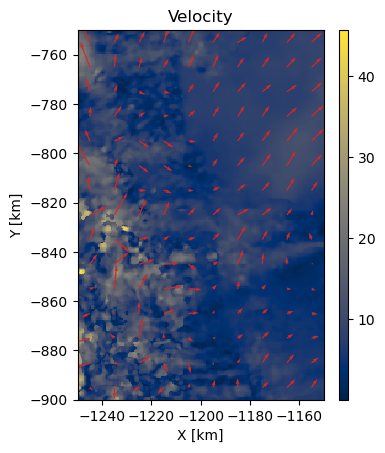

In [22]:
im = plt.pcolormesh(ds.x/1000, ds.y/1000, vel_mag, cmap='cividis')
plt.quiver(ds_coarse.x/1000, ds_coarse.y/1000, ds_coarse.vx, ds_coarse.vy, color='tab:red')
plt.axis('scaled')
plt.xlabel('X [km]')
plt.ylabel('Y [km]')
plt.title('Velocity')
plt.colorbar(im, pad=0.03, aspect=40)
plt.show()

In [23]:
kn = vd.KNeighbors(k=1)
kn.fit((xx, yy), vel_angle)

KNeighbors()

## Run variogram_params.py

In [24]:
df = pd.read_csv('variogram_params.csv')
df.head()

,x,y,vars,range,sill,smooth,major_range,minor_range
0,-1.220680e+06,-872917.096752,1.743500,12135.960516,1.884951,20.000000,14181.872760,13310.932385
1,-1.168490e+06,-820493.402752,0.956338,18234.753620,1.073913,1.366321,14124.804729,30000.000000
2,-1.197044e+06,-787184.435118,0.752873,10973.392511,0.690434,3.772055,9247.191354,15825.805336
3,-1.229620e+06,-829406.149665,1.513225,13426.513097,1.624065,2.917261,19022.825555,13452.333404
4,-1.184655e+06,-806242.221432,0.804685,13797.589309,0.822868,1.774339,11803.245835,16415.395369


In [25]:
points = np.array([df.x.values, df.y.values]).T

In [26]:
smoothing = 1e9

interp = RBFInterpolator(points, df.vars.values, smoothing=smoothing)
interp_vars = interp(np.array([xx.flatten(), yy.flatten()]).T).reshape(xx.shape)

interp = RBFInterpolator(points, df.range.values, smoothing=smoothing)
interp_ranges = interp(np.array([xx.flatten(), yy.flatten()]).T).reshape(xx.shape)

interp = RBFInterpolator(points, df.sill.values, smoothing=smoothing)
interp_sills = interp(np.array([xx.flatten(), yy.flatten()]).T).reshape(xx.shape)

interp = RBFInterpolator(points, df.smooth.values, smoothing=smoothing)
interp_smooths = interp(np.array([xx.flatten(), yy.flatten()]).T).reshape(xx.shape)
interp_smooths = np.where(interp_smooths < 1.5, 1.5, interp_smooths)
interp_smooths = np.where(interp_smooths > 20, 20, interp_smooths)

interp = RBFInterpolator(points, df.major_range.values, smoothing=smoothing)
interp_major_ranges = interp(np.array([xx.flatten(), yy.flatten()]).T).reshape(xx.shape)

interp = RBFInterpolator(points, df.minor_range.values, smoothing=smoothing)
interp_minor_ranges = interp(np.array([xx.flatten(), yy.flatten()]).T).reshape(xx.shape)

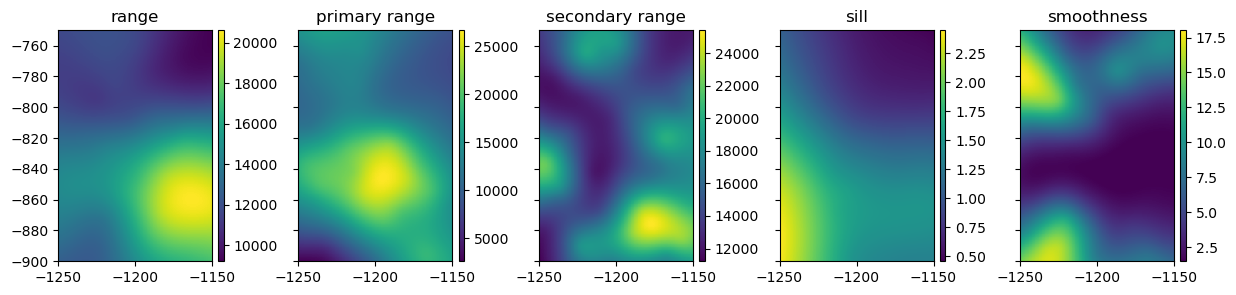

In [27]:
plots = [interp_ranges, interp_major_ranges, interp_minor_ranges, interp_sills, interp_smooths]
titles = ['range', 'primary range', 'secondary range', 'sill', 'smoothness']

fig, axs = plt.subplots(1, 5, figsize=(15,3), sharey=True)

for p, ax, title in zip(plots, axs, titles):
    im = ax.pcolormesh(ds.x/1000, ds.y/1000, p)
    ax.axis('scaled')
    ax.set_title(title)
    plt.colorbar(im, ax=ax, pad=0.03, aspect=40)
plt.show()

In [28]:
vel_angle.shape

(300, 200)

In [29]:
vario = {
    'azimuth' : vel_angle,
    'nugget' : 0,
    'major_range' : interp_major_ranges,
    'minor_range' : interp_minor_ranges,
    'sill' : interp_sills,
    's' : smoothness,
    'vtype' : 'matern'
}

sim_nonstat = interpolate.sgs(xx, yy, res_cond, vario, rad, k, seed=rng)

  0%|          | 0/60000 [00:00<?, ?it/s]

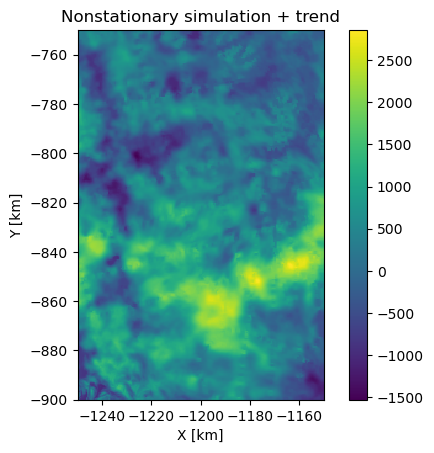

In [30]:
plt.pcolormesh(ds.x/1000, ds.y/1000, sim_nonstat+trend)
plt.axis('scaled')
plt.xlabel('X [km]')
plt.ylabel('Y [km]')
plt.title('Nonstationary simulation + trend')
plt.colorbar()
plt.show()

# Simulate only where you want to with sim_mask

In [31]:
vario = {
    'azimuth' : vel_angle,
    'nugget' : 0,
    'major_range' : interp_major_ranges,
    'minor_range' : interp_minor_ranges,
    'sill' : interp_sills,
    's' : smoothness,
    'vtype' : 'matern'
}

sim_mask = np.full(xx.shape, False)
sim_mask[100:200,50:150] = True

sim_partial = interpolate.sgs(xx, yy, bed_cond, vario, rad, k, sim_mask=sim_mask, seed=rng)

  0%|          | 0/10000 [00:00<?, ?it/s]

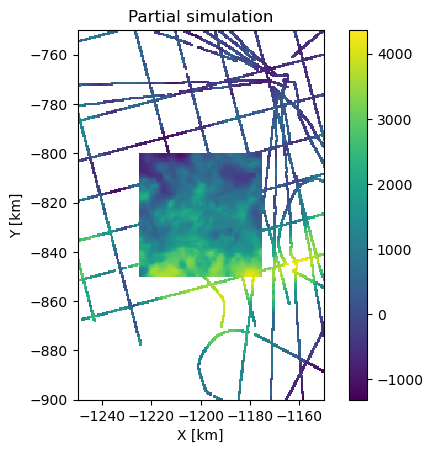

In [32]:
plt.pcolormesh(ds.x/1000, ds.y/1000, sim_partial+trend)
plt.axis('scaled')
plt.xlabel('X [km]')
plt.ylabel('Y [km]')
plt.title('Partial simulation')
plt.colorbar()
plt.show()

## Find maximum distance to cond data

In [33]:
cond_dists = utilities.dists_to_cond(xx, yy, res_cond)

  0%|          | 0/300 [00:00<?, ?it/s]

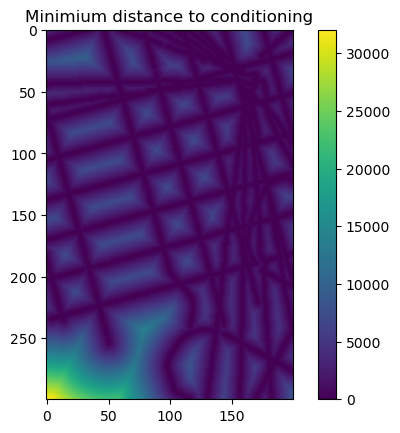

In [34]:
plt.imshow(cond_dists)
plt.title('Minimium distance to conditioning')
plt.colorbar()
plt.show()

In [35]:
np.max(cond_dists)

np.float64(32035.13671875)

In [36]:
rad = 33e3

# Use different covariance models

In [69]:
parameters = vgrams['spherical']
print(parameters)

# set variogram parameters
nugget = parameters[-1]
major_range = parameters[0]
minor_range = parameters[0]
sill = parameters[1]
azimuth = 0

[np.float64(15661.813274755916), np.float64(0.9769522431525952), 0]


In [117]:
vario_tmp = {
    'azimuth' : azimuth,
    'nugget' : nugget,
    'major_range' : major_range,
    'minor_range' : minor_range,
    'sill' : sill,
    's' : smoothness,
    'vtype' : 'spherical',
}
rng = np.random.default_rng(0)
sim_spherical = interpolate.sgs(xx, yy, res_cond, vario_tmp, rad, k, seed=rng)

  0%|          | 0/60000 [00:00<?, ?it/s]

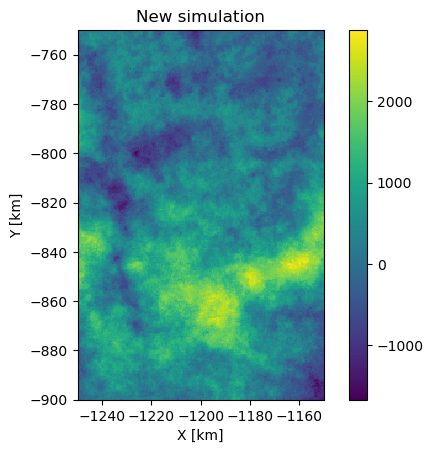

In [118]:
plt.pcolormesh(ds.x/1000, ds.y/1000, sim_spherical + trend)
plt.axis('scaled')
plt.xlabel('X [km]')
plt.ylabel('Y [km]')
plt.title('New simulation')
plt.colorbar()
plt.show()

# Use stencil for speedup (default now)

In [119]:
stencil, xx_st, yy_st = neighbors.make_circle_stencil(ds.x.values, rad)
stencil.shape

(201, 201)

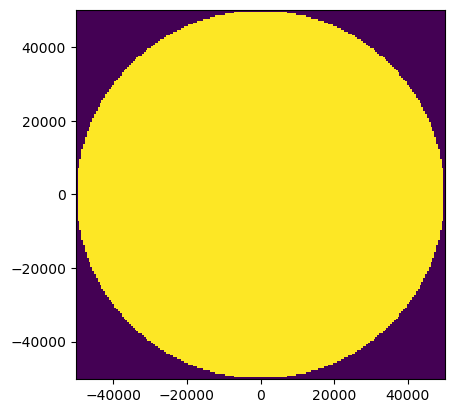

In [120]:
plt.pcolormesh(xx_st, yy_st, stencil)
plt.axis('scaled')
plt.show()

In [121]:
rng = np.random.default_rng(0)
sim_stencil = interpolate.sgs(xx, yy, res_cond, vario_tmp, rad, k, seed=rng, stencil=stencil)

  0%|          | 0/60000 [00:00<?, ?it/s]

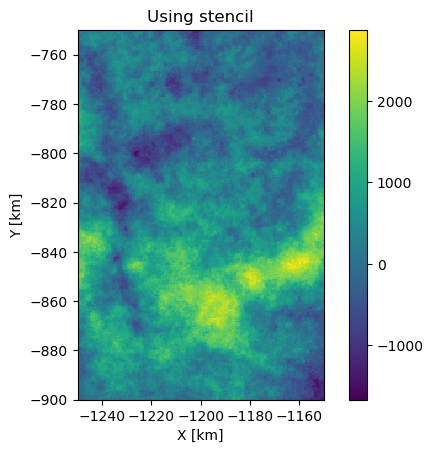

In [122]:
plt.pcolormesh(ds.x/1000, ds.y/1000, sim_stencil + trend)
plt.axis('scaled')
plt.xlabel('X [km]')
plt.ylabel('Y [km]')
plt.title('Using stencil')
plt.colorbar()
plt.show()

### Difference is negligible using same seed

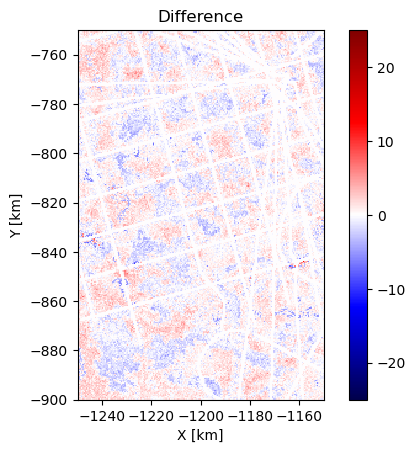

In [123]:
plt.pcolormesh(ds.x/1000, ds.y/1000, sim_spherical-sim_stencil, vmin=-25, vmax=25, cmap='seismic')
plt.axis('scaled')
plt.xlabel('X [km]')
plt.ylabel('Y [km]')
plt.title('Difference')
plt.colorbar()
plt.show()

# Simple kriging SGS

In [124]:
rng = np.random.default_rng(0)
sk_sim = interpolate.sgs(xx, yy, res_cond, vario_tmp, rad, k, ktype='sk', seed=rng)

  0%|          | 0/60000 [00:00<?, ?it/s]

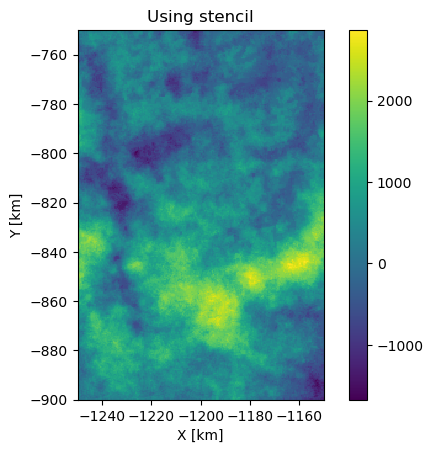

In [125]:
plt.pcolormesh(ds.x/1000, ds.y/1000, sk_sim + trend)
plt.axis('scaled')
plt.xlabel('X [km]')
plt.ylabel('Y [km]')
plt.title('Using stencil')
plt.colorbar()
plt.show()

In [267]:
k

15

# Kriging

In [284]:
parameters = vgrams['matern']
print(parameters)

# set variogram parameters
nugget = parameters[-1]
major_range = parameters[0]
minor_range = parameters[0]
sill = parameters[1]
azimuth = 0
smoothness = parameters[2]

vario = {
    'azimuth' : azimuth,
    'nugget' : nugget,
    'major_range' : major_range,
    'minor_range' : minor_range,
    'sill' : sill,
    's' : smoothness,
    'vtype' : 'matern',
}

k = 80
rad = 50e3

[np.float64(15170.521253030789), np.float64(0.9857828005329232), np.float64(1.617712940332448), 0]


In [285]:
ok_mean, ok_std = interpolate.krige(xx, yy, res_cond, vario, rad, k, ktype='ok')

  0%|          | 0/60000 [00:00<?, ?it/s]

In [286]:
ok_std = ok_std - np.min(ok_std)

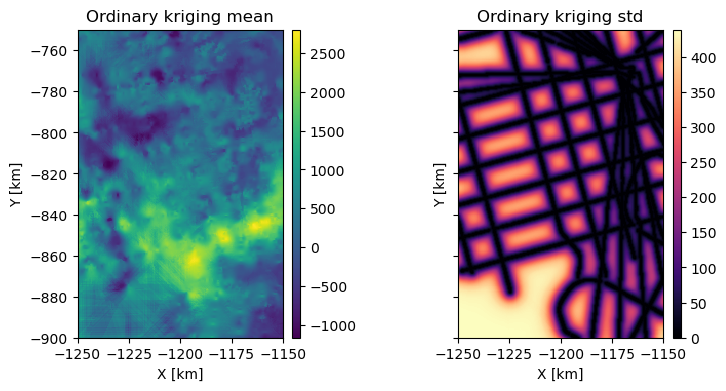

In [287]:
fig, axs = plt.subplots(1, 2, figsize=(9,4), sharey=True)
ax = axs[0]
im = ax.pcolormesh(ds.x/1000, ds.y/1000, ok_mean+trend)
ax.axis('scaled')
ax.set_title('Ordinary kriging mean')
ax.set_xlabel('X [km]')
ax.set_ylabel('Y [km]')
plt.colorbar(im, ax=ax, pad=0.03, aspect=40)

ax = axs[1]
im = ax.pcolormesh(ds.x/1000, ds.y/1000, ok_std, cmap='magma')
ax.axis('scaled')
ax.set_title('Ordinary kriging std')
ax.set_xlabel('X [km]')
ax.set_ylabel('Y [km]')
plt.colorbar(im, ax=ax, pad=0.03, aspect=40)

plt.show()

In [288]:
vario_gsm = [azimuth, nugget, major_range, minor_range, sill, 'matern', smoothness]
pred_grid = np.stack([xx.flatten(), yy.flatten()]).T
est_SK, var_SK = gsm.Interpolation.okrige(pred_grid, df_grid, 'X', 'Y', 'NormZ', k, vario_gsm, rad, quiet=False)

100%|██████████| 60000/60000 [15:58<00:00, 62.62it/s] 


In [289]:
var_SK[var_SK < 0] = 0      # make sure variances are non-negative
std_SK = np.sqrt(var_SK)    # convert to standard deviation before back transforming

# reshape
est = est_SK.reshape(-1,1)
std = std_SK.reshape(-1,1)

# back transformation
spred_trans = nst_trans.inverse_transform(est).reshape(xx.shape)
sstd_trans = nst_trans.inverse_transform(std).reshape(xx.shape)
sstd_trans = sstd_trans - np.min(sstd_trans)

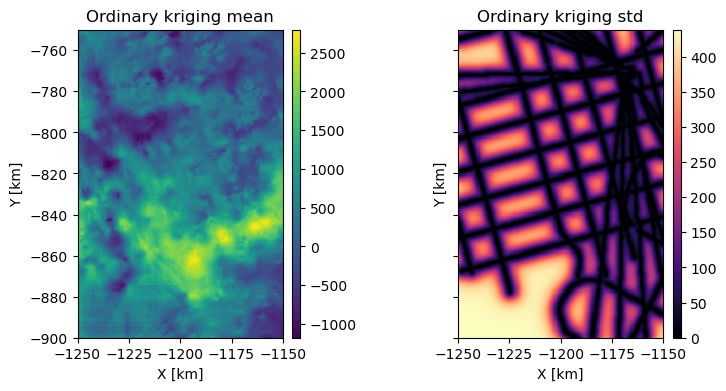

In [290]:
fig, axs = plt.subplots(1, 2, figsize=(9,4), sharey=True)
ax = axs[0]
im = ax.pcolormesh(ds.x/1000, ds.y/1000, spred_trans+trend)
ax.axis('scaled')
ax.set_title('Ordinary kriging mean')
ax.set_xlabel('X [km]')
ax.set_ylabel('Y [km]')
plt.colorbar(im, ax=ax, pad=0.03, aspect=40)

ax = axs[1]
im = ax.pcolormesh(ds.x/1000, ds.y/1000, sstd_trans, cmap='magma')
ax.axis('scaled')
ax.set_title('Ordinary kriging std')
ax.set_xlabel('X [km]')
ax.set_ylabel('Y [km]')
plt.colorbar(im, ax=ax, pad=0.03, aspect=40)

plt.show()

# Compare nearest neighbor searches

In [251]:
cond_msk_tmp = np.ones(xx.shape).astype(bool)
df_tmp = pd.DataFrame({'X' : xx.flatten(), 'Y' : yy.flatten(), 'Z' : np.zeros(xx.shape).flatten()})

In [252]:
i = 144
j = 168

ii, jj = np.meshgrid(np.arange(xx.shape[0]), np.arange(xx.shape[1]), indexing='ij')

nearest = neighbors.neighbors(i, j, ii, jj, xx, yy, res_norm, cond_msk, 50e3, 256)

In [253]:
np.shape(nearest), np.unique(nearest[:,2]).size

((256, 5), 256)

In [254]:
good_ind = np.unique(nearest[:,2], return_index=True)
good_ind[1].size

256

In [255]:
import gstatsim as gsm

df2 = df_grid.copy()
df2 = df2.rename(columns=({'NormZ' : 'Z'}))

nearest2 = gsm.NearestNeighbor.nearest_neighbor_search(50e3, 256, 
                                                  (xx[i,j], yy[i,j]), df2[['X','Y','Z']])

nearest2.shape

(256, 3)

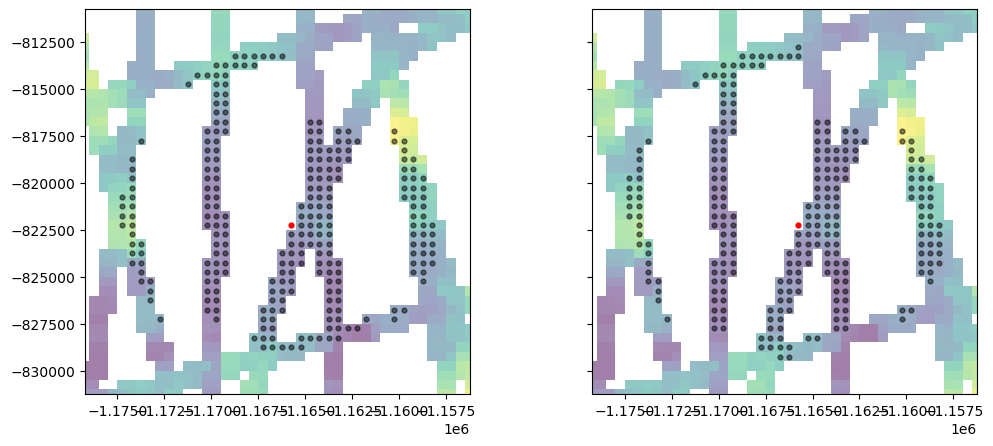

In [258]:
xmin = np.min(nearest2[:,0])-2e3
xmax = np.max(nearest2[:,0])+2e3
ymin = np.min(nearest2[:,1])-2e3
ymax = np.max(nearest2[:,1])+2e3

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(12,5))
ax = axs[0]
ax.pcolormesh(ds.x, ds.y, res_norm, vmin=np.min(nearest[:,2]), vmax=np.max(nearest[:,2]), alpha=0.5)
im = ax.scatter(nearest[:,0], nearest[:,1], c='k', s=12, alpha=0.5)
ax.scatter(xx[i,j], yy[i,j], c='r', s=12)
ax.axis('scaled')
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

ax = axs[1]
ax.pcolormesh(ds.x, ds.y, res_norm, vmin=np.min(nearest[:,2]), vmax=np.max(nearest[:,2]), alpha=0.5)
im = ax.scatter(nearest2[:,0], nearest2[:,1], c='k', alpha=0.5, s=12)
ax.scatter(xx[i,j], yy[i,j], c='r', s=12)
ax.axis('scaled')
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
plt.show()